参考：https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_6_COBA_with_astro.html

上のチューロリアルの例では抑制ニューロンに座標(x,y)が設定されおらず全て真ん中になっていた、そのためここでは「#Arrange inhibitory neurons in a grid」を加えて抑制ニューロンにも座標を与えた。

In [1]:
from brian2 import *
seed(134354)  # to get identical figures for repeated runs

In [2]:
### General parameters
duration = 60.0*second  # Total simulation time
N_e = 1600             # Number of excitatory neurons
N_i = 400              # Number of inhibitory neurons
N_a = 1600              # Number of astrocytes
I_ex = 100*pA          # External current
stimulus = TimedArray([1.0] * 60, dt=1*second) # 100 pA 単位
exc_syn_prop = 0.05    # Proportion of excitatory synapses that are connected
inh_syn_prop = 0.20    # Proportion of inhibitory synapses that are connected
size = 400*umeter      # Length and width of the square lattice, needed to establish proper connections
a_to_a_thr = 100*um    # Connect to all astrocytes less than 100um away

In [3]:
################################################################################
# Model parameters
################################################################################

### Neuron parameters
E_l = -60*mV                 # Leak reversal potential
g_l = 9.99*nS                # Leak conductance
E_e = 0*mV                   # Excitatory synaptic reversal potential
E_i = -80*mV                 # Inhibitory synaptic reversal potential
C_m = 198*pF                 # Membrane capacitance
tau_e = 5*ms                 # Excitatory synaptic time constant
tau_i = 10*ms                # Inhibitory synaptic time constant
tau_r = 5*ms                 # Refractory period
I_ex = 100*pA                # External current
V_th = -50*mV                # Firing threshold
V_r = E_l                    # Reset potential

### Synapse parameters
rho_c = 0.005                # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500.*mmolar            # Total vesicular neurotransmitter concentration
Omega_c = 40/second          # Neurotransmitter clearance rate
U_0__star = 0.6              # Resting synaptic release probability
Omega_f = 3.33/second        # Synaptic facilitation rate
Omega_d = 2.0/second         # Synaptic depression rate
w_e = 0.05*nS                # Excitatory synaptic conductance
w_i = 1.0*nS                 # Inhibitory synaptic conductance
# --- Presynaptic receptors
O_G = 1.5/umolar/second      # Agonist binding (activating) rate
Omega_G = 0.5/(60*second)    # Agonist release (deactivating) rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05*umolar            # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
# --- Agonist-dependent IP_3 production
O_beta = 0.5*umolar/second   # Maximal rate of IP_3 production by PLCbeta
O_N = 0.3/umolar/second      # Agonist binding rate
Omega_N = 0.5/second         # Maximal inactivation rate
K_KC = 0.5*umolar            # Ca^2+ affinity of PKC
zeta = 10                    # Maximal reduction of receptor affinity by PKC
# --- Endogenous IP3 production
O_delta = 1.2*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5*umolar     # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F = 0.09*umolar/second       # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion
# --- Gliotransmitter release and time course
C_Theta = 0.5*umolar         # Ca^2+ threshold for exocytosis
Omega_A = 0.6/second         # Gliotransmitter recycling rate
U_A = 0.6                    # Gliotransmitter release probability
G_T = 200*mmolar             # Total vesicular gliotransmitter concentration
rho_e = 6.5e-4               # Astrocytic vesicle-to-extracellular volume ratio
Omega_e = 60/second          # Gliotransmitter clearance rate
alpha = 0.0                  # Gliotransmission nature

In [4]:
################################################################################
# Model definition
################################################################################

### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) + I_ex*stimulus(t))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens  # post-synaptic excitatory conductance
dg_i/dt = -g_i/tau_i : siemens  # post-synaptic inhibitory conductance
# Neuron position in space
x : meter (constant)
y : meter (constant)
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]

# Arrange excitatory neurons in a grid
N_rows_e = int(sqrt(N_e))
N_cols_e = N_e//N_rows_e
grid_dist_e = (size / N_cols_e)
exc_neurons.x = '(i // N_rows_e)*grid_dist_e - N_rows_e/2.0*grid_dist_e'
exc_neurons.y = '(i % N_rows_e)*grid_dist_e - N_cols_e/2.0*grid_dist_e'

# Arrange inhibitory neurons in a grid
N_rows_i = int(sqrt(N_i))
N_cols_i = N_i//N_rows_i
grid_dist_i = (size / N_cols_i)
inh_neurons.x = '(i // N_rows_i)*grid_dist_i - N_rows_i/2.0*grid_dist_i'
inh_neurons.y = '(i % N_rows_i)*grid_dist_i - N_cols_i/2.0*grid_dist_i'

# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'

### Synapses
synapses_eqs = '''
# Neurotransmitter
dY_S/dt = -Omega_c * Y_S                                    : mmolar (clock-driven)
# Fraction of activated presynaptic receptors
dGamma_S/dt = O_G * G_A * (1 - Gamma_S) - Omega_G * Gamma_S : 1 (clock-driven)
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S                                    : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available for release:
dx_S/dt = Omega_d *(1 - x_S)                                : 1 (event-driven)
U_0                                                         : 1
# released synaptic neurotransmitter resources:
r_S                                                         : 1
# gliotransmitter concentration in the extracellular space:
G_A                                                         : mmolar
# which astrocyte covers this synapse ?
astrocyte_index : integer (constant)
'''
synapses_action = '''
U_0 = (1 - Gamma_S) * U_0__star + alpha * Gamma_S
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
Y_S += rho_c * Y_T * r_S
'''
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',
                   method='exact')
exc_syn.connect(True, p=exc_syn_prop)
exc_syn.x_S = 1.0
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S',
                   method='exact')
inh_syn.connect(True, p=inh_syn_prop)
inh_syn.x_S = 1.0

# Connect excitatory synapses to an astrocyte depending on the position of the post-synaptic neuron
N_rows_a = int(sqrt(N_a))
N_cols_a = N_a//N_rows_a
grid_dist_a = size / N_rows_a
exc_syn.astrocyte_index = ('int(x_post/grid_dist_a) + N_cols_a*int(y_post/grid_dist_a)')

### Astrocytes
# The astrocyte emits gliotransmitter when its Ca^2+ concentration crosses a threshold
astro_eqs = '''
# Fraction of activated astrocyte receptors:
dGamma_A/dt = O_N * Y_S * (1 - clip(Gamma_A,0,1)) - Omega_N*(1 + zeta * C/(C + K_KC)) * clip(Gamma_A,0,1) : 1
# Intracellular IP_3
dI/dt = J_beta + J_delta - J_3K - J_5P + J_coupling              : mmolar
J_beta = O_beta * Gamma_A                                        : mmolar/second
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Diffusion between astrocytes:
J_coupling                                                       : mmolar/second

# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# Fraction of gliotransmitter resources available for release:
dx_A/dt = Omega_A * (1 - x_A) : 1
# gliotransmitter concentration in the extracellular space:
dG_A/dt = -Omega_e*G_A        : mmolar
# Neurotransmitter concentration in the extracellular space:
Y_S                           : mmolar
# The astrocyte position in space
x : meter (constant)
y : meter (constant)
'''
glio_release = '''
G_A += rho_e * G_T * U_A * x_A
x_A -= U_A *  x_A
'''
astrocytes = NeuronGroup(N_a, astro_eqs,
                         # The following formulation makes sure that a "spike" is
                         # only triggered at the first threshold crossing
                         threshold='C>C_Theta',
                         refractory='C>C_Theta',
                         # The gliotransmitter release happens when the threshold
                         # is crossed, in Brian terms it can therefore be
                         # considered a "reset"
                         reset=glio_release,
                         method='rk4',
                         dt=1e-2*second)
# Arrange astrocytes in a grid
astrocytes.x = '(i // N_rows_a)*grid_dist_a - N_rows_a/2.0*grid_dist_a'
astrocytes.y = '(i % N_rows_a)*grid_dist_a - N_cols_a/2.0*grid_dist_a'
# Add random initialization
astrocytes.C = 0.01*umolar
astrocytes.h = 0.9
astrocytes.I = 0.01*umolar
astrocytes.x_A = 1.0

ecs_astro_to_syn = Synapses(astrocytes, exc_syn,
                            'G_A_post = G_A_pre : mmolar (summed)')
ecs_astro_to_syn.connect('i == astrocyte_index_post')
ecs_syn_to_astro = Synapses(exc_syn, astrocytes,
                            'Y_S_post = Y_S_pre/N_incoming : mmolar (summed)')
ecs_syn_to_astro.connect('astrocyte_index_pre == j')
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre            : mmolar
J_coupling_post = -(1 + tanh((abs(delta_I) - I_Theta)/omega_I))*
                  sign(delta_I)*F/2 : mmolar/second (summed)
'''
astro_to_astro = Synapses(astrocytes, astrocytes, model=astro_to_astro_eqs)
astro_to_astro.connect('i != j and sqrt((x_pre-x_post)**2 +(y_pre-y_post)**2) < a_to_a_thr')

In [5]:
################################################################################
# Monitors
################################################################################
# Note that we could use a single monitor for all neurons instead, but this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)
ast_mon = SpikeMonitor(astrocytes)

In [6]:
################################################################################
# Simulation run
################################################################################
run(duration, report='text')

Starting simulation at t=0. s for a duration of 60. s
0.4587 s (0%) simulated in 10s, estimated 21m 38s remaining.
0.9107 s (1%) simulated in 20s, estimated 21m 38s remaining.
1.3761 s (2%) simulated in 30s, estimated 21m 18s remaining.
1.8454 s (3%) simulated in 40s, estimated 21m 1s remaining.
2.3089 s (3%) simulated in 50s, estimated 20m 49s remaining.
2.717 s (4%) simulated in 1m 0s, estimated 21m 5s remaining.
3.0631 s (5%) simulated in 1m 10s, estimated 21m 41s remaining.
3.4416 s (5%) simulated in 1m 20s, estimated 21m 55s remaining.
3.8864 s (6%) simulated in 1m 30s, estimated 21m 40s remaining.
4.3401 s (7%) simulated in 1m 40s, estimated 21m 23s remaining.
4.7961 s (7%) simulated in 1m 50s, estimated 21m 6s remaining.
5.2473 s (8%) simulated in 2m 0s, estimated 20m 52s remaining.
5.7047 s (9%) simulated in 2m 10s, estimated 20m 38s remaining.
6.1756 s (10%) simulated in 2m 20s, estimated 20m 20s remaining.
6.6601 s (11%) simulated in 2m 30s, estimated 20m 2s remaining.
7.1469

30.2768 s (50%) simulated in 20m 50s, estimated 20m 28s remaining.
30.3253 s (50%) simulated in 21m 0s, estimated 20m 34s remaining.
30.3739 s (50%) simulated in 21m 10s, estimated 20m 39s remaining.
30.4224 s (50%) simulated in 21m 20s, estimated 20m 45s remaining.
30.471 s (50%) simulated in 21m 30s, estimated 20m 51s remaining.
30.5197 s (50%) simulated in 21m 40s, estimated 20m 56s remaining.
30.5682 s (50%) simulated in 21m 50s, estimated 21m 2s remaining.
30.6168 s (51%) simulated in 22m 0s, estimated 21m 8s remaining.
30.6654 s (51%) simulated in 22m 10s, estimated 21m 13s remaining.
30.7139 s (51%) simulated in 22m 20s, estimated 21m 18s remaining.
30.7624 s (51%) simulated in 22m 30s, estimated 21m 24s remaining.
30.811 s (51%) simulated in 22m 40s, estimated 21m 29s remaining.
30.8597 s (51%) simulated in 22m 50s, estimated 21m 34s remaining.
30.9082 s (51%) simulated in 23m 0s, estimated 21m 40s remaining.
30.9568 s (51%) simulated in 23m 10s, estimated 21m 45s remaining.
31

36.2412 s (60%) simulated in 41m 31s, estimated 27m 14s remaining.
36.288 s (60%) simulated in 41m 41s, estimated 27m 15s remaining.
36.3347 s (60%) simulated in 41m 51s, estimated 27m 16s remaining.
36.383 s (60%) simulated in 42m 1s, estimated 27m 17s remaining.
36.4312 s (60%) simulated in 42m 11s, estimated 27m 18s remaining.
36.4792 s (60%) simulated in 42m 21s, estimated 27m 19s remaining.
36.5274 s (60%) simulated in 42m 31s, estimated 27m 20s remaining.
36.5757 s (60%) simulated in 42m 41s, estimated 27m 21s remaining.
36.6239 s (61%) simulated in 42m 51s, estimated 27m 22s remaining.
36.672 s (61%) simulated in 43m 1s, estimated 27m 22s remaining.
36.7202 s (61%) simulated in 43m 11s, estimated 27m 23s remaining.
36.7686 s (61%) simulated in 43m 22s, estimated 27m 24s remaining.
36.8169 s (61%) simulated in 43m 32s, estimated 27m 25s remaining.
36.8651 s (61%) simulated in 43m 42s, estimated 27m 25s remaining.
36.9133 s (61%) simulated in 43m 52s, estimated 27m 26s remaining.


42.116 s (70%) simulated in 1h 2m 3s, estimated 26m 21s remaining.
42.1643 s (70%) simulated in 1h 2m 13s, estimated 26m 19s remaining.
42.2123 s (70%) simulated in 1h 2m 23s, estimated 26m 17s remaining.
42.2605 s (70%) simulated in 1h 2m 33s, estimated 26m 15s remaining.
42.3087 s (70%) simulated in 1h 2m 43s, estimated 26m 14s remaining.
42.3566 s (70%) simulated in 1h 2m 53s, estimated 26m 12s remaining.
42.4047 s (70%) simulated in 1h 3m 3s, estimated 26m 10s remaining.
42.4528 s (70%) simulated in 1h 3m 13s, estimated 26m 8s remaining.
42.501 s (70%) simulated in 1h 3m 23s, estimated 26m 6s remaining.
42.5492 s (70%) simulated in 1h 3m 33s, estimated 26m 4s remaining.
42.5974 s (70%) simulated in 1h 3m 43s, estimated 26m 2s remaining.
42.6455 s (71%) simulated in 1h 3m 53s, estimated 26m 0s remaining.
42.6938 s (71%) simulated in 1h 4m 3s, estimated 25m 58s remaining.
42.7421 s (71%) simulated in 1h 4m 13s, estimated 25m 56s remaining.
42.7902 s (71%) simulated in 1h 4m 23s, esti

47.842 s (79%) simulated in 1h 21m 54s, estimated 20m 49s remaining.
47.8908 s (79%) simulated in 1h 22m 4s, estimated 20m 45s remaining.
47.9396 s (79%) simulated in 1h 22m 14s, estimated 20m 41s remaining.
47.9877 s (79%) simulated in 1h 22m 24s, estimated 20m 38s remaining.
48.0364 s (80%) simulated in 1h 22m 34s, estimated 20m 34s remaining.
48.0852 s (80%) simulated in 1h 22m 44s, estimated 20m 30s remaining.
48.134 s (80%) simulated in 1h 22m 54s, estimated 20m 26s remaining.
48.1827 s (80%) simulated in 1h 23m 4s, estimated 20m 23s remaining.
48.2315 s (80%) simulated in 1h 23m 14s, estimated 20m 19s remaining.
48.2803 s (80%) simulated in 1h 23m 24s, estimated 20m 15s remaining.
48.3291 s (80%) simulated in 1h 23m 34s, estimated 20m 11s remaining.
48.3778 s (80%) simulated in 1h 23m 44s, estimated 20m 7s remaining.
48.4266 s (80%) simulated in 1h 23m 54s, estimated 20m 3s remaining.
48.4754 s (80%) simulated in 1h 24m 4s, estimated 19m 59s remaining.
48.5242 s (80%) simulated i

53.5902 s (89%) simulated in 1h 41m 35s, estimated 12m 9s remaining.
53.6391 s (89%) simulated in 1h 41m 45s, estimated 12m 4s remaining.
53.688 s (89%) simulated in 1h 41m 55s, estimated 11m 59s remaining.
53.7369 s (89%) simulated in 1h 42m 5s, estimated 11m 54s remaining.
53.7858 s (89%) simulated in 1h 42m 15s, estimated 11m 49s remaining.
53.8345 s (89%) simulated in 1h 42m 25s, estimated 11m 44s remaining.
53.8833 s (89%) simulated in 1h 42m 35s, estimated 11m 39s remaining.
53.9321 s (89%) simulated in 1h 42m 45s, estimated 11m 34s remaining.
53.981 s (89%) simulated in 1h 42m 55s, estimated 11m 29s remaining.
54.0298 s (90%) simulated in 1h 43m 5s, estimated 11m 24s remaining.
54.0787 s (90%) simulated in 1h 43m 15s, estimated 11m 18s remaining.
54.1276 s (90%) simulated in 1h 43m 25s, estimated 11m 13s remaining.
54.1765 s (90%) simulated in 1h 43m 35s, estimated 11m 8s remaining.
54.2253 s (90%) simulated in 1h 43m 45s, estimated 11m 3s remaining.
54.2741 s (90%) simulated in

59.4435 s (99%) simulated in 2h 1m 36s, estimated 1m 8s remaining.
59.4922 s (99%) simulated in 2h 1m 46s, estimated 1m 2s remaining.
59.54 s (99%) simulated in 2h 1m 57s, estimated 57s remaining.
59.5886 s (99%) simulated in 2h 2m 7s, estimated 51s remaining.
59.6364 s (99%) simulated in 2h 2m 17s, estimated 45s remaining.
59.6848 s (99%) simulated in 2h 2m 27s, estimated 39s remaining.
59.7323 s (99%) simulated in 2h 2m 37s, estimated 33s remaining.
59.7809 s (99%) simulated in 2h 2m 47s, estimated 27s remaining.
59.8281 s (99%) simulated in 2h 2m 57s, estimated 21s remaining.
59.8765 s (99%) simulated in 2h 3m 7s, estimated 15s remaining.
59.9246 s (99%) simulated in 2h 3m 17s, estimated 9s remaining.
59.9734 s (99%) simulated in 2h 3m 27s, estimated 3s remaining.
60. s (100%) simulated in 2h 3m 32s


[(0, 50.0),
 Text(0, 0.5, 'rate (Hz)'),
 (0.0, 60000.0),
 Text(0.5, 0, 'time (ms)')]

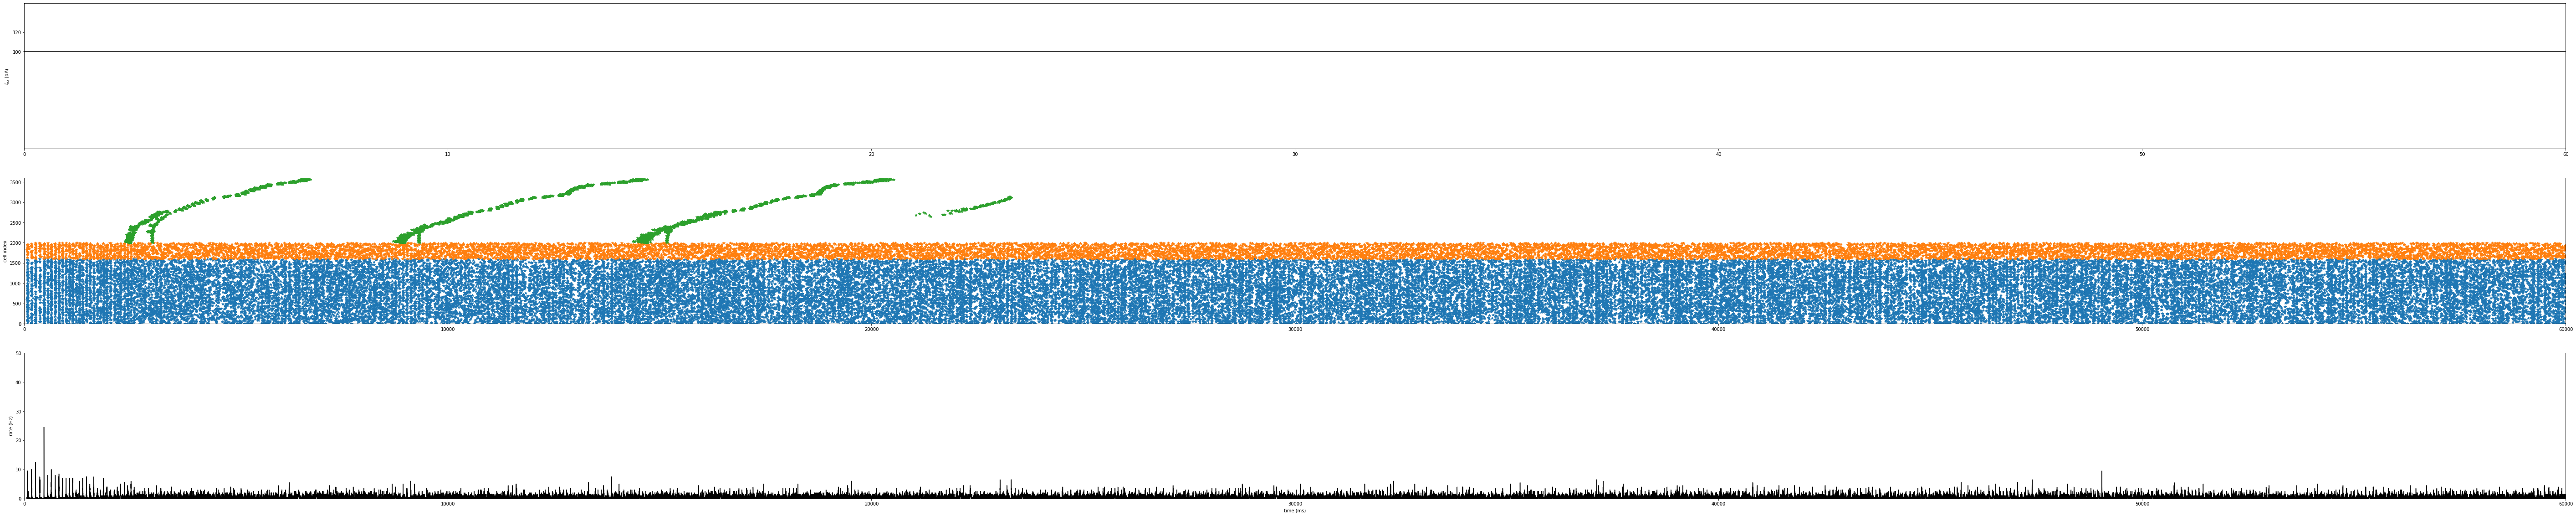

In [7]:
################################################################################
# Analysis and plotting
################################################################################
fig1, ax = plt.subplots(nrows=3, ncols=1, figsize=(100, 20))

# Input current
time_range = np.linspace(0, int(duration/second), int(duration/second)*100)*second
ax[0].plot(time_range, I_ex*stimulus(time_range)/pA, 'k')
ax[0].set(xlim=(0, duration/second), ylim=(0, 150), yticks=[100, 120], ylabel='$I_{ex}$ (pA)')

##Spiking activity (w/ rate)
ax[1].plot(exc_mon.t[exc_mon.i <= N_e]/ms, exc_mon.i[exc_mon.i <= N_e], '*', color='C0')
ax[1].plot(inh_mon.t[inh_mon.i <= N_i]/ms, inh_mon.i[inh_mon.i <= N_i]+N_e, '*', color='C1')
ax[1].plot(ast_mon.t[ast_mon.i <= N_a]/ms, ast_mon.i[ast_mon.i <= N_a]+(N_e+N_i), '*', color='C2')
ax[1].set(xlim=(0., duration/ms), ylim=(0, (N_e+N_i+N_a)), ylabel='cell index')

# Generate frequencies
bin_size = 1*ms
spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/ms, inh_mon.t/ms], int(duration/ms))
rate = double(spk_count)/(N_e + N_i)/bin_size/Hz
ax[2].plot(bin_edges[:-1], rate, '-', color='k')
ax[2].set(xlim=(0., duration/ms), ylim=(0, 50.), xlabel='time (ms)', ylabel='rate (Hz)')